One example of a nonsequential neural network is a Wide & Deep neural network

It connects all or part of the inputs directly to the output layer

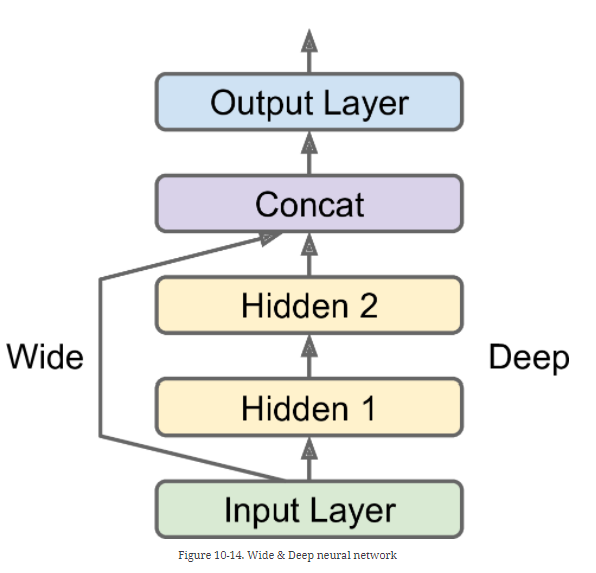

This architecture makes it possible for the neural network to learn both deep patterns (using the deep path) and simple rules (through the short path)

In contrast, a regular MLP forces all the data to flow through the full stack of layers; thus, simple patterns in the data may end up being distorted by this sequence of transformations.

Let’s build such a neural network to tackle the California housing problem:

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full)

"""
removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as:

z = (x - u) / s
"""
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [7]:
import tensorflow as tf
from tensorflow import keras

In [9]:
"""
First, we need to create an Input object. 
This is a specification of the kind of input the model will get, including its shape and dtype. 
A model may actually have multiple inputs, as we will see shortly.
"""
input_ = keras.layers.Input(shape=X_train.shape[1:])
"""
Next, we create a Dense layer with 30 neurons, using the ReLU activation function. 
As soon as it is created, notice that we call it like a function, passing it the input. 
This is why this is called the Functional API. 
Note that we are just telling Keras how it should connect the layers together; no actual data is being processed yet.
"""
hidden1 = keras.layers.Dense(30, activation="relu")(input_)

"""
We then create a second hidden layer, and again we use it as a function. 
Note that we pass it the output of the first hidden layer.
"""
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
"""
Next, we create a Concatenate layer, and once again we immediately use it like a function, to concatenate the input and 
the output of the second hidden layer. 
You may prefer the keras.layers.concatenate() function, which creates a Concatenate layer and 
immediately calls it with the given inputs.
"""
concat = keras.layers.Concatenate()([input_, hidden2])
"""
Then we create the output layer, with a single neuron and no activation function, 
and we call it like a function, passing it the result of the concatenation.
"""
output = keras.layers.Dense(1)(concat)
"""
Lastly, we create a Keras Model, specifying which inputs and outputs to use.
"""
model = keras.Model(inputs=[input_], outputs=[output])

Once you have built the Keras model, everything is exactly like earlier, so there’s no need to repeat it here: you must compile the model, train it, evaluate it, and use it to make predictions

But what if you want to send a subset of the features through the wide path and a different subset (possibly overlapping) through the deep path 

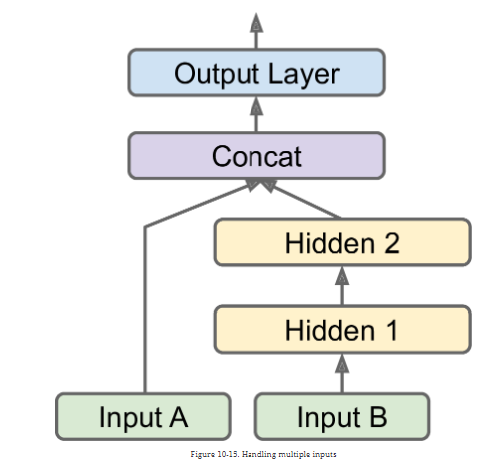

In this case, one solution is to use multiple inputs. For example, suppose we want to send five features through the wide path (features 0 to 4), and six features through the deep path (features 2 to 7):

In [10]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.Model(inputs=[input_A, input_B], outputs=[output])

Now we can compile the model as usual, but when we call the fit() method, instead of passing a single input matrix X_train, we must pass a pair of matrices (X_train_A, X_train_B): one per input

The same is true for X_valid, and also for X_test and X_new when you call evaluate() or predict():

In [11]:

     
    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

C:\Users\jenni\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
363/363 [==============================] - 3s 6ms/step - loss: 2.1403 - val_loss: 0.9940
Epoch 2/20
363/363 [==============================] - 3s 7ms/step - loss: 0.8491 - val_loss: 0.7635
Epoch 3/20
363/363 [==============================] - 2s 7ms/step - loss: 0.7190 - val_loss: 0.6833
Epoch 4/20
363/363 [==============================] - 2s 6ms/step - loss: 0.6631 - val_loss: 0.6409
Epoch 5/20
363/363 [==============================] - 2s 6ms/step - loss: 0.6292 - val_loss: 0.6119
Epoch 6/20
363/363 [==============================] - 2s 4ms/step - loss: 0.6048 - val_loss: 0.5898
Epoch 7/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5855 - val_loss: 0.5728
Epoch 8/20
363/363 [==============================] - 2s 7ms/step - loss: 0.5701 - val_loss: 0.5582
Epoch 9/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5577 - val_loss: 0.5469
Epoch 10/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5471 - val_loss: 0.5378

Another use case is as a regularization technique (i.e., a training constraint whose objective is to reduce overfitting and thus improve the model’s ability to generalize). For example, you may want to add some auxiliary outputs in a neural network architecture (see Figure 10-16) to ensure that the underlying part of the network learns something useful on its own, without relying on the rest of the network.

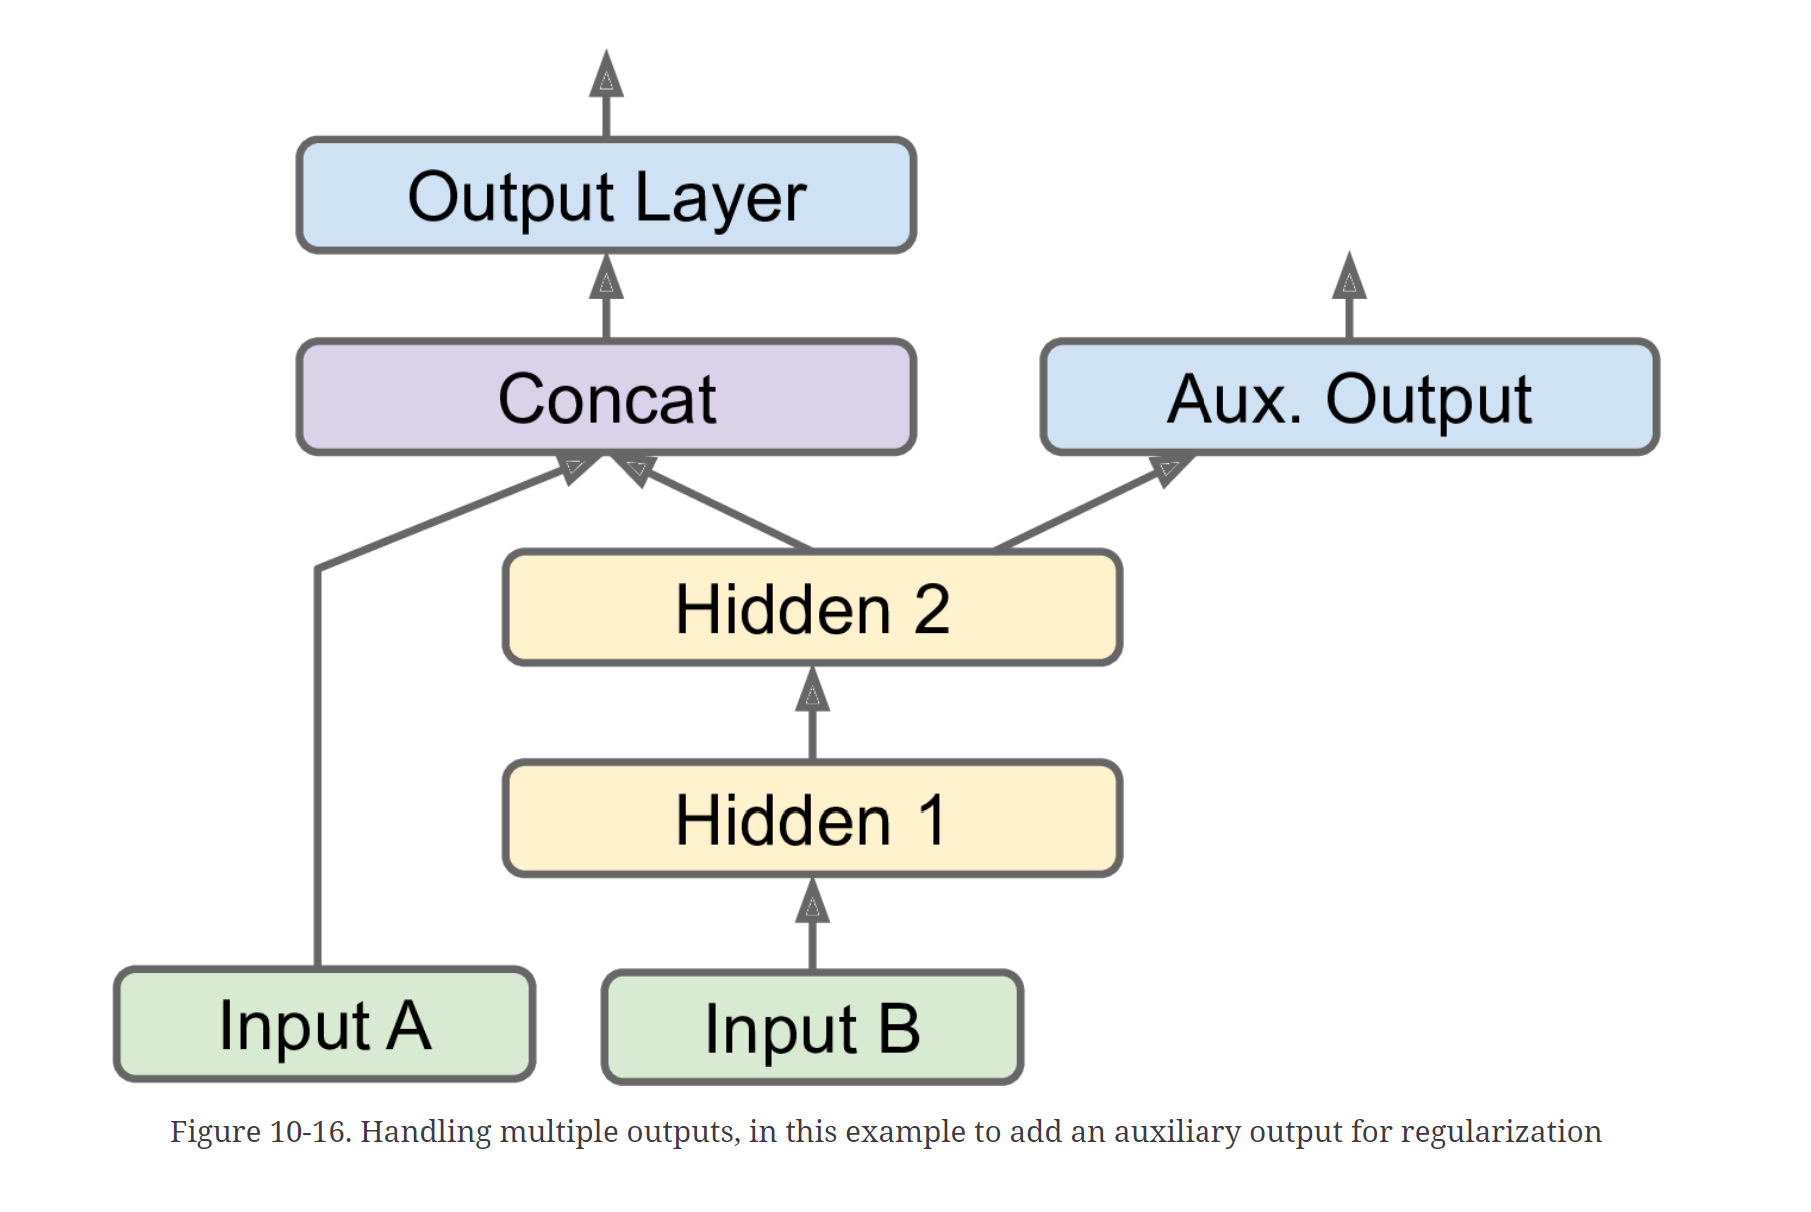

Adding extra outputs is quite easy: just connect them to the appropriate layers and add them to your model’s list of outputs

In [13]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output]) 

Each output will need its own loss function. Therefore, when we compile the model, we should pass a list of losses (if we pass a single loss, Keras will assume that the same loss must be used for all outputs)

By default, Keras will compute all these losses and simply add them up to get the final loss used for training. 

We care much more about the main output than about the auxiliary output (as it is just used for regularization), so we want to give the main output’s loss a much greater weight. 

Fortunately, it is possible to set all the loss weights when compiling the model

In [14]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer="sgd")

Now when we train the model, we need to provide labels for each output. 

In this example, the main output and the auxiliary output should try to predict the same thing, so they should use the same labels. 

So instead of passing y_train, we need to pass (y_train, y_train) (and the same goes for y_valid and y_test)

In [15]:
history = model.fit(
    [X_train_A, X_train_B], [y_train, y_train], epochs=20,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 5s 7ms/step - loss: 1.0020 - output_loss: 0.8896 - aux_output_loss: 2.0139 - val_loss: 0.6363 - val_output_loss: 0.5695 - val_aux_output_loss: 1.2381
Epoch 2/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6014 - output_loss: 0.5454 - aux_output_loss: 1.1051 - val_loss: 0.5769 - val_output_loss: 0.5275 - val_aux_output_loss: 1.0215
Epoch 3/20
363/363 [==============================] - 2s 4ms/step - loss: 0.5495 - output_loss: 0.5077 - aux_output_loss: 0.9256 - val_loss: 0.5213 - val_output_loss: 0.4817 - val_aux_output_loss: 0.8775
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5193 - output_loss: 0.4863 - aux_output_loss: 0.8167 - val_loss: 0.5035 - val_output_loss: 0.4720 - val_aux_output_loss: 0.7874
Epoch 5/20
363/363 [==============================] - 2s 6ms/step - loss: 0.5418 - output_loss: 0.5162 - aux_output_loss: 0.7730 - val_loss: 0.4996 - val_output_loss: 0.4712 - val_aux_

When we evaluate the model, Keras will return the total loss, as well as all the individual losses:

In [16]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])

162/162 [==============================] - 0s 2ms/step - loss: 0.3819 - output_loss: 0.3686 - aux_output_loss: 0.5012


Similarly, the predict() method will return predictions for each output:

In [18]:
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])
print(y_pred_main)
print(y_pred_aux)

[[1.1985102]
 [1.6097411]
 [1.6667376]]
[[1.736222 ]
 [1.7603147]
 [1.5679741]]
